# Chapter 5
## Question 3

### Author: Ou, Dongwen

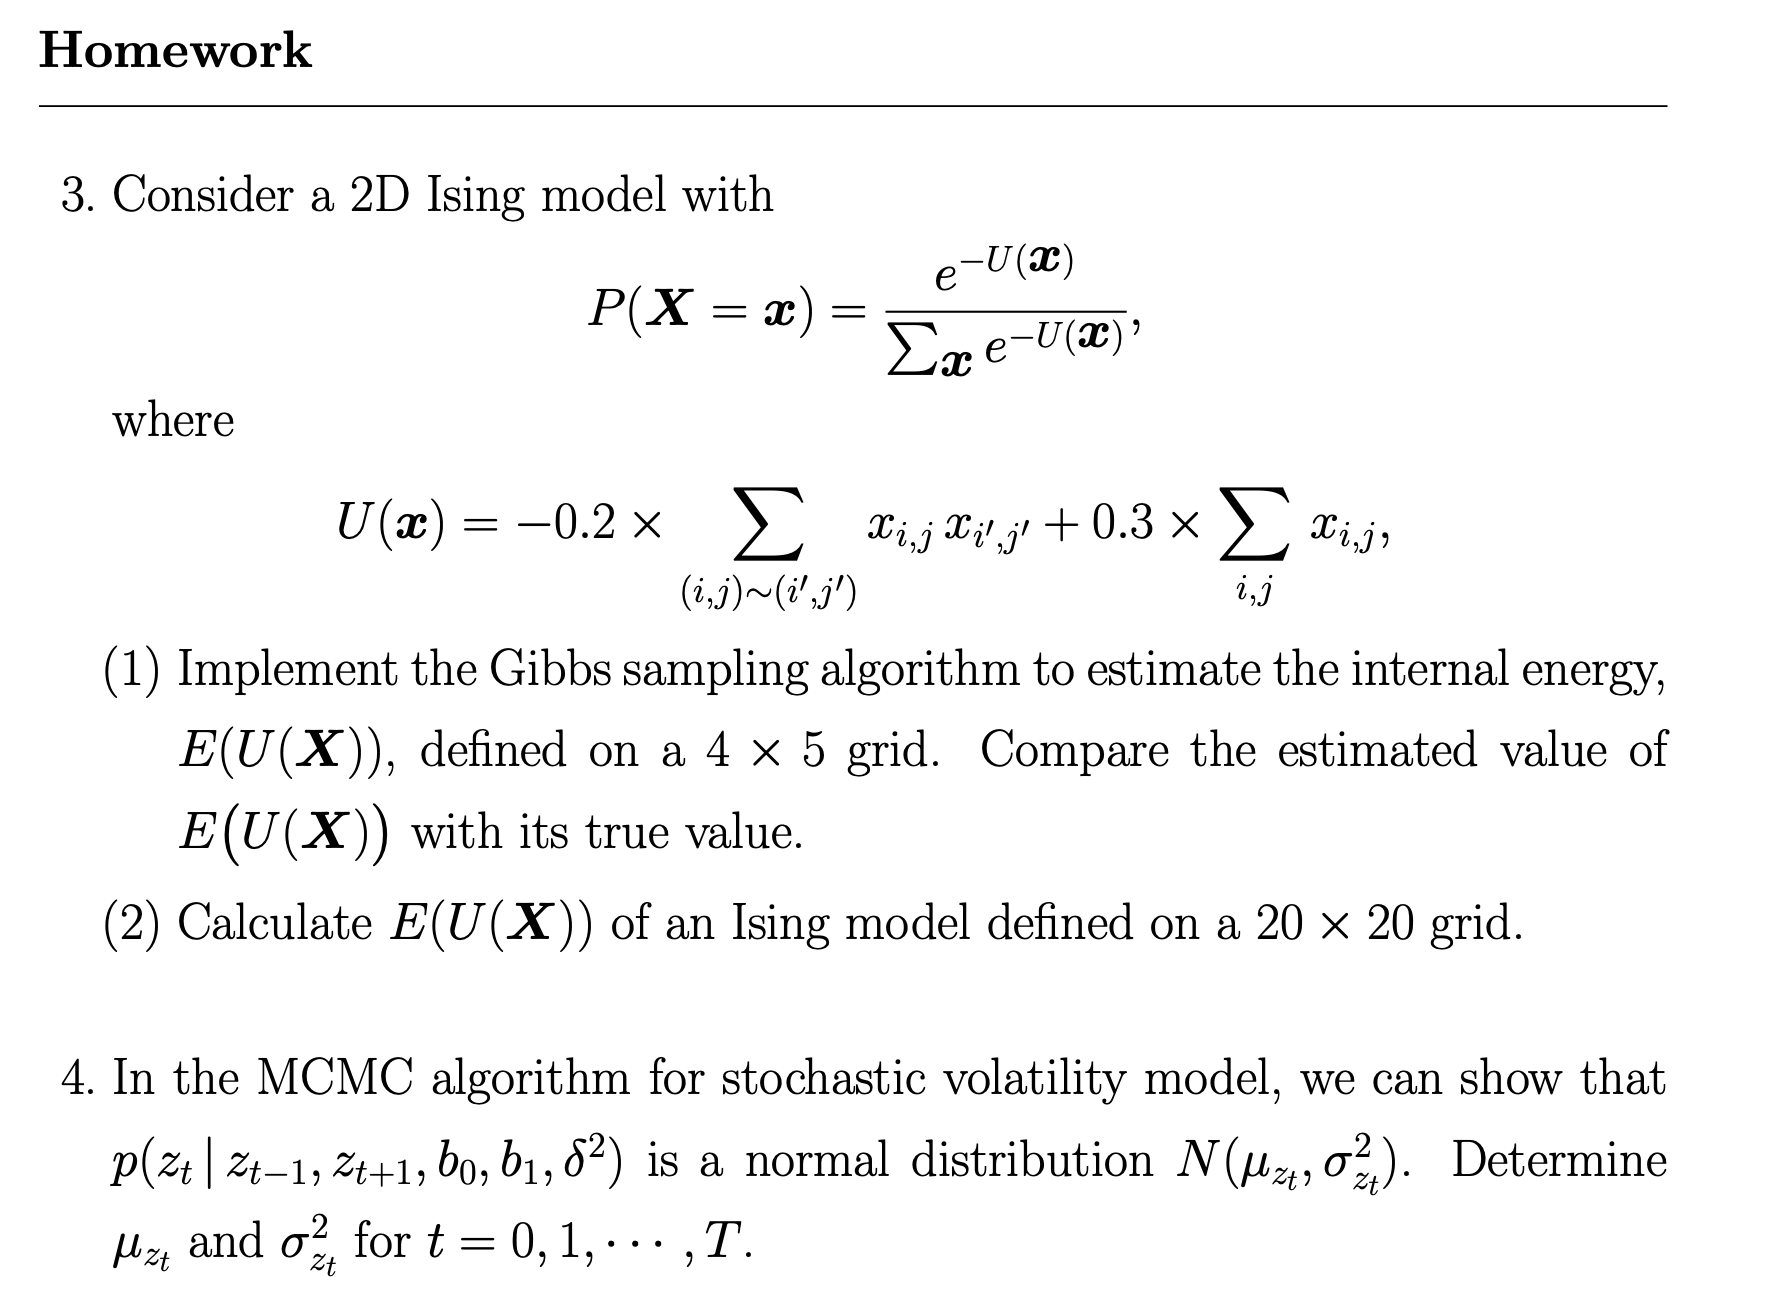

In [11]:
import numpy as np
import itertools

# ---------------------
# 参数设置
# ---------------------
J = -0.2         # 相互作用系数（负值表示倾向于邻居同号，即自旋一致）
h = 0.3          # 外加磁场强度（正值表示倾向于+1）
rows, cols = 4, 5
N = rows * cols  # 总格点数（例如 4*5=20）

# ---------------------
# 预处理每个格点的邻居索引（在1D向量里表示2D邻接）
# ---------------------
def get_neighbors(index, rows, cols):
    i, j = divmod(index, cols)  # 将1D索引转为2D坐标，index是0~19的1D index
    neighbors = []
    if i > 0: neighbors.append((i - 1) * cols + j)      # 上方邻居
    if i < rows - 1: neighbors.append((i + 1) * cols + j)  # 下方邻居
    if j > 0: neighbors.append(i * cols + (j - 1))      # 左侧邻居
    if j < cols - 1: neighbors.append(i * cols + (j + 1))  # 右侧邻居
    return neighbors

# 计算所有点的邻居列表
neighbors_list = [get_neighbors(idx, rows, cols) for idx in range(N)]

# ---------------------
# calculate U[x] given a kind of possible x 
# ---------------------
def compute_energy(x): # x is in 1D form
    interaction_energy = 0.0  # interaction term
    field_energy = 0.0        # single term
    for idx in range(N):
        xi = x[idx] 
        for neighbor in neighbors_list[idx]:
            interaction_energy += xi * x[neighbor]  # interaction
        field_energy += xi
    interaction_energy /= 2  # 每个相互作用被算了两次，除以2去重
    return J * interaction_energy + h * field_energy

# ---------------------
# enumerate all 2^N possible X
# ---------------------
configs = list(itertools.product([-1, 1], repeat=N))  # 这会生成所有长度为 N 的元组，其中每个元素取自 [-1, 1]
# itertools.product(...) 本身是一个迭代器：它不会一次性生成所有组合；节省内存，只在遍历时计算下一个组合
# use list(...) 是将其一次性展开为列表，可以随时反复访问所有配置。


# ---------------------
# Calculate weight sum Z and E[U]
# ---------------------
Z = 0.0   # 配分函数（所有权重之和）
EU = 0.0  # 带权重的总能量，用于计算期望

for config in configs:
    Ux = compute_energy(config)       # 计算该配置的能量
    weight = np.exp(-Ux)              # 权重 ∝ e^{-U(x)}
    Z += weight                       # 累加配分函数
    EU += Ux * weight                 # 累加期望的分子部分

expected_U = EU / Z                   # 最终计算期望 E[U]
print("True Expected Internal Energy:", expected_U)

True Expected Internal Energy: -5.647457464068214


In [25]:
import numpy as np
from tqdm import tqdm
import pandas as pd

# ---------------------
# Gibbs sampling with 1D representation
# ---------------------
def get_neighbors_1d(index, rows, cols):
    """Given a 1D index, return the indices of its neighbors in 1D."""
    i, j = divmod(index, cols)
    neighbors = []
    if i > 0: neighbors.append((i - 1) * cols + j)
    if i < rows - 1: neighbors.append((i + 1) * cols + j)
    if j > 0: neighbors.append(i * cols + (j - 1))
    if j < cols - 1: neighbors.append(i * cols + (j + 1))
    return neighbors

def compute_energy_1d(x, neighbors_list, J, h):
    """Compute total energy given a 1D spin configuration."""
    interaction_energy = 0.0
    field_energy = 0.0
    for idx in range(len(x)):
        xi = x[idx]
        for neighbor in neighbors_list[idx]:
            interaction_energy += xi * x[neighbor]
        field_energy += xi
    interaction_energy /= 2  # avoid double-counting
    return J * interaction_energy + h * field_energy

def local_energy_1d(idx, spin_val, x, neighbors_list, J, h):
    """
    计算第 idx 个格点，在当前状态 x 下，假设它取值 spin_val 时的局部能量。
    参数：
    - idx: 当前要更新的格点在 1D 表示中的索引（0 ~ N-1）
    - spin_val: 当前格点尝试设置的自旋值（+1 或 -1）
    - x: 当前系统状态，是一个 1D 向量（长度 N）
    - neighbors_list: 所有格点的邻居索引列表（由 get_neighbors 生成）
    """ # 因为求和被e扛起来后变为product，然后不变的部分被上下抵消，所以只需要算局部改变的能量就好
    neighbor_sum = sum(x[neighbor] for neighbor in neighbors_list[idx])  # 邻居的总自旋和
    return J * spin_val * neighbor_sum + h * spin_val                    # 返回局部能量

def gibbs_sampling_1d(rows=4, cols=5, iterations=12000, burn_in=2000, J=-0.2, h=0.3):
    N = rows * cols
    x = np.random.choice([-1, 1], size=N)  # initial 1D configuration
    neighbors_list = [get_neighbors_1d(idx, rows, cols) for idx in range(N)]
    energies = []

    for it in tqdm(range(iterations)):
        for idx in range(N):
            # compute unnormalized probabilities for spin = +1 and -1
            e_pos = local_energy_1d(idx, 1, x, neighbors_list, J, h)
            e_neg = local_energy_1d(idx, -1, x, neighbors_list, J, h)
            p_pos = np.exp(-e_pos)
            p_neg = np.exp(-e_neg)
            prob = p_pos / (p_pos + p_neg)
            x[idx] = 1 if np.random.rand() < prob else -1
        if it >= burn_in:
            energies.append(compute_energy_1d(x, neighbors_list, J, h))

    return np.mean(energies), np.std(energies)

# Run for 4x5 and 20x20 grid
mean_4x5, std_4x5 = gibbs_sampling_1d(4, 5)
mean_20x20, std_20x20 = gibbs_sampling_1d(20, 20)

results_df = pd.DataFrame({
    "Grid Size": ["4x5", "20x20"],
    "Mean Energy": [mean_4x5, mean_20x20],
    "Std Dev": [std_4x5, std_20x20]
})

print(results_df)

100%|████████████████████████████████████| 12000/12000 [00:17<00:00, 686.98it/s]

  Grid Size  Mean Energy    Std Dev
0       4x5     -5.70664   2.796847
1     20x20   -143.58190  14.624591


## Question 4.
### For t=0
\begin{eqnarray*}
% \nonumber % Remove numbering (before each equation)
   && P(z_0\vert z_1,\theta) \\
   &\propto& P(z_0\vert\theta)P(z_1\vert z_0,\theta) \\
   &\propto & \exp\{-\frac{(z_0-\mu_0)^2}{2\eta_0^2}\}\exp\{-\frac{(z_1-b_0-b_1z_0)^2}{2\delta^2}\} \\
   &=& \exp\{-\frac{(z_0-\mu_{z_0})^2}{2\sigma^2_{z_0}}\}
\end{eqnarray*}

where
\begin{equation*}
  \mu_{z_0}=\frac{\mu_0\delta^2+b_1(z_1-b_0)}{\delta^2+b_1^2\eta_0^2}\quad \sigma^2_{z_0}=\frac{\eta_0^2\delta^2}{\delta^2+b_1^2\eta_0^2}
\end{equation*}

### For $t=1,...,T-1$
\begin{eqnarray*}
% \nonumber % Remove numbering (before each equation)
   && P(z_t\vert z_{t-1},z_{t+1},\theta) \\
   &\propto& P(z_t\vert z_{t-1},\theta)P(z_{t+1}\vert z_t,\theta) \\
   &\propto& \exp\{-\frac{(z_t-b_1z_{t-1}-b_0)^2}{2\delta^2}\}\exp\{-\frac{(z_{t+1}-b_1z_{t}-b_0)^2}{2\delta^2}\} \\
 & \propto &\exp\left\{ -\frac{1}{2\delta^{2}}\left[ b_{1}^{2}z_{t}^{2}-2b_{1}\left(z_{t+1}-b_{0}\right)z_{t}+z_{t}^{2}-2\left(b_{0}+b_{1}z_{t-1}\right)z_{t}\right]\right\} \\
 & =& \exp\left\{ -\frac{b_{1}^{2}+1}{2\delta^{2}}\left(z_{t}^{2}-2\times\frac{b_{1}\left(z_{t+1}-b_{0}\right)+\left(b_{0}+b_{1}z_{t-1}\right)}{b_{1}^{2}+1}z_{t}\right)\right\} \\
 & \propto& \exp\left\{ -\frac{b_{1}^{2}+1}{2\delta^{2}}\left(z_{t}-\frac{b_{1}\left(z_{t+1}+z_{t-1}\right)-b_{1}b_{0}+b_{0}}{b_{1}^{2}+1}\right)^{2}\right\}
\end{eqnarray*}

then,
\begin{equation*}
  \mu_{z_t}=\frac{b_0+b_1(z_{t-1}+z_{t+1})-b_0b_1}{1+b_1^2}\quad \sigma^2_{z_t}=\frac{\delta^2}{1+b_1^2}
\end{equation*}

### For t=T
\begin{eqnarray*}
% \nonumber % Remove numbering (before each equation)
   & P(z_T\vert z_{0:T-1},\theta) =P(z_T\vert z_{T-1},\theta) \sim N(b_0+b_1 z_{T-1},\delta^2)
\end{eqnarray*}
then 
\begin{equation*}
  \mu_{z_T}=b_0+b_1 z_{T-1} \quad \sigma^2_{z_T}=\delta^2
\end{equation*}